In [13]:
import numpy as np
from prettytable import PrettyTable

T=11
states_range = [-10,11]
action_range = [0,10]
random_demand = [0,10]
to_add = 10
p=4
a,b=5,5

def h(X):
    if X >= 0:
        return a * X
    else:
        return -b * X

def check(state):
    return state>=states_range[0] and state<states_range[1]

def cost(X,U):
    return h(X)+p*U

V=np.zeros((T+2,states_range[1]-states_range[0]))

Demand = [np.random.randint(random_demand[0], random_demand[1]) for _ in range(T + 10)]

for _ in range(1000000):

    for s in range(states_range[0], states_range[1]):
       V[T][s + to_add] = h(s)

    for t in range(T-1,-1,-1):
        for X in range(states_range[0],states_range[1]):
            min_cost = float('inf')
            temp_cost = 0
            cnt=0
            for U in range(action_range[0],action_range[1]):
                # next_state = X+U-np.random.randint(random_demand[0],random_demand[1])
                next_state = X+U-Demand[t]
                if(check(next_state)):
                    temp_cost += cost(next_state,U)+V[t+1][next_state + to_add]
                    cnt+=1
            if(cnt>0):
                temp_cost/=cnt
                if temp_cost<min_cost:
                    min_cost = temp_cost
                V[t][X+to_add] = min_cost

# Print Policy from V
policy = np.zeros((T + 1,states_range[1]-states_range[0] + 1))
for t in range(T + 1):
    for X in range(states_range[0],states_range[1] + 1):
        min_cost = float('inf')
        for U in range(action_range[0],action_range[1] + 1):
            # next_state = X+U-np.random.randint(random_demand[0],random_demand[1])
            next_state = X+U-Demand[t]
            # next_state = X+U
            if(check(next_state)):
                temp_cost = cost(next_state,U)+V[t+1][next_state+to_add]
                if temp_cost<min_cost:
                    min_cost = temp_cost
                    policy[t][X+to_add] = U

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
from prettytable import PrettyTable

T = 10
states_range = [-10, 10]
action_range = 10
random_demand = 10
to_add = 10
p = 4
a, b = 5,5
def h(X):
    if X >= 0:
        return a * X
    else:
        return -b * X

def check(state):
    return states_range[0] <= state < states_range[1]

def cost(X, U):
    return h(X) + p * U

def get_next_state(X, U, time):
    return max(states_range[0], min(states_range[1], X + U - Demand[time]))

# 100000
def monte_carlo_inventory(start_state, start_time_arr, start_action ,rewards_per_episode, lr=0.5, gamma=0.999, num_episodes=1000000, exploration_decreasing_decay=0.995, min_exploration_proba=0.01, epsilon=1):
    # Q = np.zeros((states_range[1] - states_range[0] + 1,T, action_range + 1))
    Q = np.full((states_range[1] - states_range[0] + 1, T, action_range + 1), 1e8)
    count = np.zeros((states_range[1] - states_range[0] + 1,T, action_range + 1))

    # for s in range(states_range[0], states_range[1] + 1):
    #     for a in range(action_range + 1):
    #         Q[T - 1][s + to_add][a] = h(s)

    Returns = []
    for state in range(states_range[0], states_range[1] + 1):
        state_returns = []
        for t in range(T + 1):
            time_returns = []
            for action in range(action_range + 1):
                action_returns = []
                time_returns.append(action_returns)
            state_returns.append(time_returns)
        Returns.append(state_returns)

    for episode_num in range(num_episodes):
#         if episode_num % 10000 == 0:
#             print(episode_num)

        total_episode_cost = 0
        # curr_state= np.random.randint(states_range[0], states_range[1])
        curr_state = episode_num % (states_range[1] - states_range[0] + 1)
        curr_state -= (states_range[1])
        episode = []

        time = np.random.randint(0, T)
        start_state.append((curr_state + to_add, time))
        start_time = time
        start_time_arr.append(start_time)

        while time < T:
            # print(num_episodes , time , curr_state)
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0 , action_range+1)
            else:
                action = np.argmin(Q[curr_state + to_add, time, :])

            if time == start_time:
                start_action.append(action)

            count[curr_state + to_add][time][action] += 1
            # reward = cost(curr_state, action)
            next_state = get_next_state(curr_state, action, time)
            reward = cost(next_state, action)
            episode.append((curr_state, action, reward))
            # total_episode_cost = total_episode_cost * gamma + reward

            total_episode_reward=reward*math.pow(gamma,t-start_time)

            curr_state = next_state

            time += 1

        G = 0
        for t in reversed(range(len(episode))):
            G = gamma * G + episode[t][2]
            Returns[episode[t][0] + to_add][start_time + t][episode[t][1]].append(G)
            Q[episode[t][0] + to_add][start_time + t][episode[t][1]] = np.mean(Returns[episode[t][0] + to_add][start_time + t][episode[t][1]])

        epsilon = max(min_exploration_proba, epsilon*exploration_decreasing_decay)
        rewards_per_episode.append(total_episode_cost)

    return Q



In [54]:
rewards_per_episode = []
start_state = []  # Initial state for inventory
start_time_arr = []
start_action = []
Q = monte_carlo_inventory(start_state, start_time_arr, start_action , rewards_per_episode)

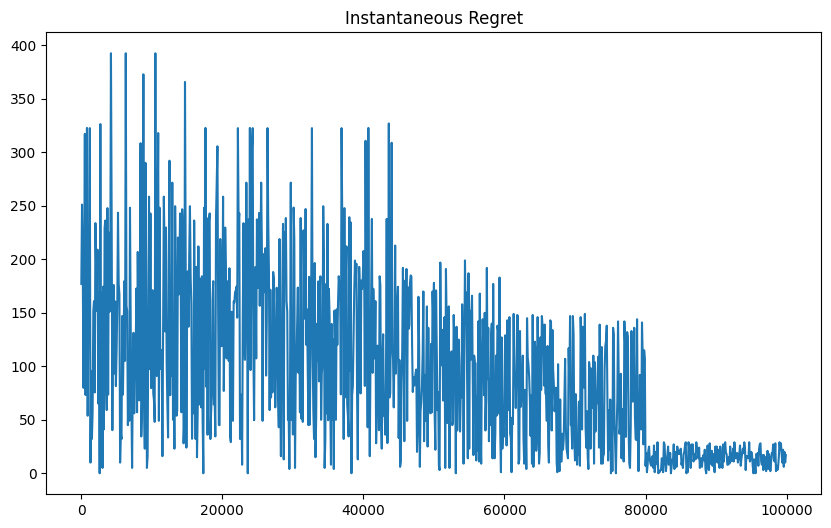

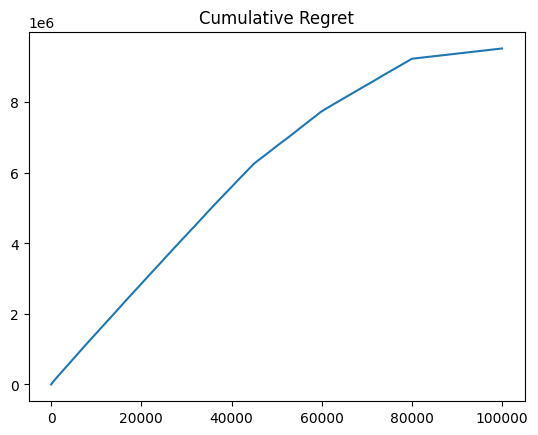

In [53]:
import matplotlib.pyplot as plt

time_ = []
regrets=[]
V = V.T
for i in range(0,len(start_state)):
    regrets.append(V[start_state[i]] - rewards_per_episode[i])
    time_.append(i)
    

plt.figure(figsize=(10, 6))
plt.plot(time_[::100],regrets[::100])
plt.title("Instantaneous Regret")
plt.show()

#plot the cumulative regret
arr_tot = np.cumsum(regrets)
plt.plot(time_,arr_tot)
plt.title("Cumulative Regret")
plt.show()

In [20]:
optimal_action = [[0 for _ in range(2*states_range[1]+1)] for _ in range(T)] # stages * states

for n in range(T):
    for i in range(states_range[0], states_range[1]+1):
        optimal_action[n][i+states_range[1]] = np.argmin(Q[i+to_add, n])

# Create a PrettyTable
table = PrettyTable()

# Add column headers
col_labels = list( range(states_range[0], states_range[1]+1) )
table.field_names = [""] + col_labels

# Add rows with values



row_labels = list( range(T) )
for i in range(len(row_labels)):
    table.add_row([row_labels[i]] + optimal_action[i])

# Print the table
print(table)

+---+-----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+----+
|   | -10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
+---+-----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+----+
| 0 |  10 | 9  | 10 | 9  | 7  | 4  | 10 | 8  | 6  | 7  | 5 | 3 | 5 | 3 | 3 | 2 | 0 | 5 | 0 | 0 | 0  |
| 1 |  0  | 10 | 10 | 9  | 10 | 10 | 10 | 10 | 9  | 9  | 7 | 7 | 7 | 4 | 4 | 2 | 0 | 0 | 1 | 7 | 0  |
| 2 |  10 | 10 | 9  | 10 | 9  | 8  | 7  | 8  | 5  | 6  | 5 | 2 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 6 | 1  |
| 3 |  8  | 7  | 6  | 9  | 5  | 7  | 2  | 3  | 4  | 3  | 2 | 1 | 0 | 3 | 3 | 2 | 6 | 0 | 0 | 0 | 1  |
| 4 |  3  | 8  | 7  | 9  | 9  | 8  | 5  | 7  | 9  | 7  | 3 | 2 | 6 | 5 | 2 | 7 | 1 | 1 | 0 | 0 | 2  |
| 5 |  1  | 9  | 10 | 9  | 10 | 10 | 9  | 9  | 8  | 7  | 7 | 6 | 3 | 2 | 6 | 1 | 4 | 0 | 0 | 0 | 0  |
| 6 |  10 | 9  | 7  | 10 | 9  | 10 | 9  | 10 | 6  | 6  | 4 | 4 | 5 | 2 | 1 | 1 | 1